
# 🧠 Educational LLM Training: Minimal Transformer vs MoE

This notebook walks through training a **small LLM** with two architectures:

1. **Minimal Transformer (baseline)**  
2. **Mixture of Experts (MoE)** variant  

We’ll train both on a tiny dataset so it runs on a free **Google Colab T4 GPU**.  


In [1]:

!pip install torch torchvision transformers datasets matplotlib --quiet


## 📂 Dataset: TinyStories (small text dataset for quick experiments)

In [2]:

from datasets import load_dataset
from transformers import AutoTokenizer

# Load TinyStories or small text dataset
dataset = load_dataset("roneneldan/TinyStories", split="train[:1%]")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

def tokenize_fn(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = dataset.map(tokenize_fn, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

from torch.utils.data import DataLoader
train_loader = DataLoader(tokenized_dataset, batch_size=16, shuffle=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/21197 [00:00<?, ? examples/s]

## 🔹 Baseline: Minimal Transformer

In [3]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class MinimalLLM(nn.Module):
    def __init__(self, vocab_size, d_model=256, n_heads=4, n_layers=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.lm_head = nn.Linear(d_model, vocab_size)

    def forward(self, x, attention_mask=None):
        x = self.embedding(x)
        x = self.transformer(x)
        return self.lm_head(x)


## 🔹 MoE: Mixture of Experts

In [4]:

class MoE(nn.Module):
    def __init__(self, vocab_size, d_model=256, n_heads=4, n_layers=4, num_experts=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.experts = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads) for _ in range(num_experts)
        ])
        self.gating = nn.Linear(d_model, num_experts)
        self.lm_head = nn.Linear(d_model, vocab_size)

    def forward(self, x, attention_mask=None):
        x = self.embedding(x)
        gate_scores = torch.softmax(self.gating(x), dim=-1)
        expert_outs = torch.stack([expert(x) for expert in self.experts], dim=0)
        x = torch.einsum("bse,ebsd->bsd", gate_scores, expert_outs)
        return self.lm_head(x)


## 🚀 Training Function

In [5]:

import torch.optim as optim

def train_model(model, dataloader, epochs=2, lr=1e-4):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    losses = []
    for epoch in range(epochs):
        for batch in dataloader:
            x = batch["input_ids"].to(device)
            y = batch["input_ids"].to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
        print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")
    return losses


## 🏋️ Train Both Models

In [6]:

baseline = MinimalLLM(vocab_size=len(tokenizer))
moe = MoE(vocab_size=len(tokenizer))

losses_baseline = train_model(baseline, train_loader)
losses_moe = train_model(moe, train_loader)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1 - Loss: 0.3311
Epoch 2 - Loss: 0.0771
Epoch 1 - Loss: 0.4176
Epoch 2 - Loss: 0.0833


## 📊 Compare Training Loss

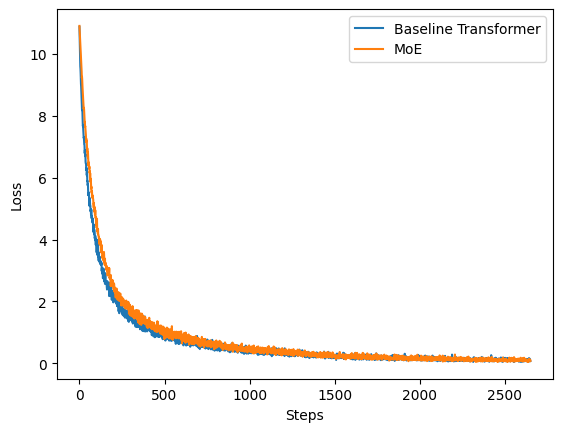

In [7]:

import matplotlib.pyplot as plt

plt.plot(losses_baseline, label="Baseline Transformer")
plt.plot(losses_moe, label="MoE")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()
